In [1]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


# Preliminares

En este documento ajustaremos algunos modelos de regresión logística a los datos sobre venta de vinos. Para ello, utilizamos el conjunto de datos que generamos tras la depuración, asegurando un conjunto de datos "limpios" y exentos de ciertos peligros. 

Antes de leer los datos vamos a intentar trabajar con el archivo de funciones que tenemos creado para no tener necesidad de definir cada función cuando queramos utilizarla. Para ello leemos el archiv.py y lo ejecutamos. Dos variante: import si el archivo está en la carpeta del documento o execfile si está en otro directorio. 


In [2]:
# Si las funciones están en esta misma carpeta podemos hacer
#from NuestrasFunciones import *
#import NuestrasFunciones 

# De lo contrario podemos hacer algo así como...
#execfile('C:\\Users\\Guille\\Documents\\MineriaDatos_2022_23_Online\\NuestrasFunciones.py')

# O bien esto
exec(open(r'C:\Users\Guille\Documents\Material Minería de Datos 2023_2024\Materíal Minería de Datos 2023_24_Gr3\NuestrasFunciones.py').read())


In [3]:
import pandas as pd
import numpy as np


# Leer datos depurados datosvinoDep
vinosDep = pd.read_hdf(r'C:\Users\Guille\Documents\Material Minería de Datos 2023_2024\Materíal Minería de Datos 2023_24_Gr3\PARTE I_Depuracion y Regresiones\Dia1_MDDepuracion\DatosVinoDep_winsRand.h5','df')

# Descriptivo de comprobación
vinosDep.head()


ID  Acidez  AcidoCitrico  Azucar  CloruroSodico  Densidad    pH  Sulfatos  \
0   2    0.16         -0.81   26.10         -0.425   1.02792  3.38      0.70   
1   4    2.64         -0.88   14.80          0.037   0.99518  3.12      0.48   
2   8    0.29         -0.40   21.50          0.060   0.99572  3.49      1.21   
3  11   -1.22          0.34    1.40          0.040   1.03236  3.20     -0.93   
4  12    0.27          1.05   11.25         -0.007   0.99620  4.93      0.26   

   Alcohol  CalifProductor  PrecioBotella Etiqueta Clasificacion Region  \
0     10.3               2           1.00        M           ***  Reg 1   
1     22.0               3           3.38        M           ***  Reg 3   
2     10.3               3           3.72        R          Desc  Reg 1   
3     11.6               2           6.23        B           ***  Reg 2   
4     15.0               1           2.44        R          Desc  Reg 2   

   prop_missings  Beneficio Compra  
0       7.142857        515      1  
1       0.000000        585      1  
2       0.000000          0      0  
3       7.142857        775      1  
4       0.000000        596      1

In [4]:
vinosDep.info()



<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 0 to 6364
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   int64   
 1   Acidez          6365 non-null   float64 
 2   AcidoCitrico    6365 non-null   float64 
 3   Azucar          6365 non-null   float64 
 4   CloruroSodico   6365 non-null   float64 
 5   Densidad        6365 non-null   float64 
 6   pH              6365 non-null   float64 
 7   Sulfatos        6365 non-null   float64 
 8   Alcohol         6365 non-null   float64 
 9   CalifProductor  6365 non-null   int64   
 10  PrecioBotella   6365 non-null   float64 
 11  Etiqueta        6365 non-null   category
 12  Clasificacion   6365 non-null   category
 13  Region          6365 non-null   category
 14  prop_missings   6365 non-null   float64 
 15  Beneficio       6365 non-null   int64   
 16  Compra          6365 non-null   category
dtypes: category(4), flo

Procedemos a la lectura de los datos depurados. Ya que vamos a hacer cosas como evaluación de las relaciones entre los predictores y la respuesta o creación masiva de transformaciones para< conseguir linealidad, lo mejor es separar las respuestas y quedarnos con el input depurado, de esta forma podemos aplicar una misma función a todo el conjunto sin peligro de transformar las respuestas y cosas raras que puedan suceder. 



In [5]:
# Lista de columnas con menos de 10 valores distintos. Potenciales factores!
to_factor = list(vinosDep.loc[:,vinosDep.nunique() < 10]);  

# Podemos cambiar el tipo de todas ellas a factor de una vez
vinosDep[to_factor] = vinosDep[to_factor].astype('category')

# Ordenmaos categorías de los fatcores de interés
vinosDep["Etiqueta"] = vinosDep["Etiqueta"].cat.reorder_categories(['MM','M','R','B','MB'])
vinosDep["Clasificacion"] = vinosDep["Clasificacion"].cat.reorder_categories(['Desc','*','**','***','****'])


**Variables de control**

No es mala idea generar un par de variables de "control" para la evaluación de los efectos de los predictores frente a la respuesta. La idea es la siguiente: si generamos variables en el más estricto sentido aleatorio (por ejemplo siguiendo una distribución uniforme[0,1]) cualquier relación que estas presenten con la variable respuesta serán debidas puramente al azar, con lo que se pueden considerar relaciones espurias, es decir, falsas. 

Por tanto, ya sea en la inspección preliminar de relaciones con la respuesta mediante correlación (relación lineal, válido para continua-continua) o VCramer (asociación en tablas de contingencia, válido para cruce de variables categóricas/nominales o continuas tramificadas) o bien en los propios modelos de regresión, las variables que presenten una menor relación con la respuesta que las variables de control, tendrán una sombra de sospecha sobre la veracidad de esa relación y probablemente serán descartadas, al menos en su estado original (siempre se pueden tratar de transformar, tramificar etc)


In [6]:
vinosDep['aleatorio'] = np.random.uniform(0,1,size=vinosDep.shape[0])
vinosDep['aleatorio2'] = np.random.uniform(0,1,size=vinosDep.shape[0])
vinosDep.head()


ID  Acidez  AcidoCitrico  Azucar  CloruroSodico  Densidad    pH  Sulfatos  \
0   2    0.16         -0.81   26.10         -0.425   1.02792  3.38      0.70   
1   4    2.64         -0.88   14.80          0.037   0.99518  3.12      0.48   
2   8    0.29         -0.40   21.50          0.060   0.99572  3.49      1.21   
3  11   -1.22          0.34    1.40          0.040   1.03236  3.20     -0.93   
4  12    0.27          1.05   11.25         -0.007   0.99620  4.93      0.26   

   Alcohol  CalifProductor  PrecioBotella Etiqueta Clasificacion Region  \
0     10.3               2           1.00        M           ***  Reg 1   
1     22.0               3           3.38        M           ***  Reg 3   
2     10.3               3           3.72        R          Desc  Reg 1   
3     11.6               2           6.23        B           ***  Reg 2   
4     15.0               1           2.44        R          Desc  Reg 2   

  prop_missings  Beneficio Compra  aleatorio  aleatorio2  
0      7.142857        515      1   0.014616    0.101451  
1      0.000000        585      1   0.575839    0.537694  
2      0.000000          0      0   0.815105    0.402570  
3      7.142857        775      1   0.749861    0.716633  
4      0.000000        596      1   0.863697    0.239191

In [7]:
# Eliminar variable objetivo continua 
varObjBin = vinosDep.Compra
imputDep = vinosDep.drop(['ID','Beneficio','Compra'],axis=1)


## Estudio descriptivo de relaciones con la respuesta

En este apartado intentaremos descubrir a priori las relaciones marginales de las variables con la variable objetivo binaria para hacernos una idea de cuales de ellas serán potencialmente influyentes en los modelos de regresión logística que ajustemos. 


In [8]:
# Aplicar la función al input completo contra la objetivo
tablaCramer = pd.DataFrame(imputDep.apply(lambda x: cramers_v(x,varObjBin)),columns=['VCramer'])

# Obtener el gráfico de importancia de las variables frente a la objetivo continua según vcramer
import plotly.express as px
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a Compra').update_yaxes(categoryorder="total ascending").show()


En este caso tenemos que las variables tentativas para el modelado son: 

- Clasificación 
- Calificación del productor 
- pH
- CloruroSodico
- Sulfatos
- Acidez

A partir de aquí ya tenemos prop_missings y empezamos a sospechar que más allá de esta las relaciones pueden ser por pura casualidad...pero habrá que asegurar en modelo. 

Vamos ahora a utilizar las funciones gráficas para pintar las relaciones de las variables con la objetivo binaria. En primer lugar podemos utilizar la función mosaico que es resultona para las relaciones entre categóricas y las de boxplot e histograma para valorar las relaciones de los predictores continuos con la objetivo binaria.


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

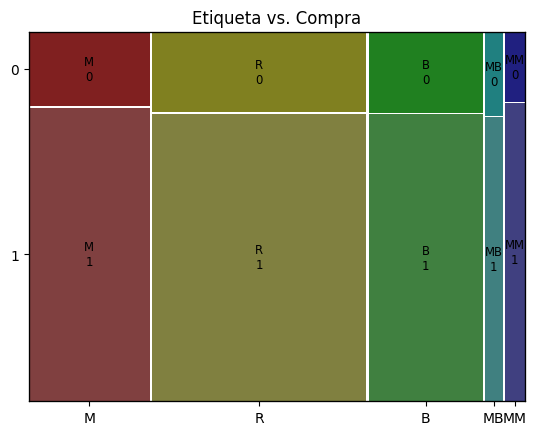

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

plt.clf()
#mosaic(pd.crosstab(vinosDep.Clasificacion, varObjBin))
mosaic(vinosDep,['Clasificacion','Compra'],gap=0.005, title='Clasificacion vs. Compra')
#sns.heatmap(pd.crosstab(vinosDep.Etiqueta, varObjBin))
plt.show()

plt.clf()
#mosaic(pd.crosstab(vinosDep.Clasificacion, varObjBin))
mosaic(vinosDep,['Etiqueta','Compra'],gap=0.005, title='Etiqueta vs. Compra')
#sns.heatmap(pd.crosstab(vinosDep.Etiqueta, varObjBin))
plt.show()

plt.clf()
#mosaic(pd.crosstab(vinosDep.Clasificacion, varObjBin))
mosaic(vinosDep,['Region','Compra'],gap=0.005, title='Region vs. Compra')
#sns.heatmap(pd.crosstab(vinosDep.Etiqueta, varObjBin))
plt.show()


Como ya intuíamos por el gráfico de V de Cramer, la pobre variable región no discrimina nada frente a la compra del vino (nuestra objetivo binaria) ya que las distribuciones de 0 y 1 en las distintas regiones son muy similares digamos 20/80%?? 

En cambio, la variable clasificación tiene mucho que aportar ya que vemos que las distribuciones de 0 y 1 en los distintos niveles de clasificación son muy distintos. Así, empezamos a intuir que los vinos con clasificación desconocida parecen ser vinos malillos en general al menos en el sentido de que no se compran. Parece que existe una relación relativamente creciente de proporción de compra con el aumento de las estrellas de clasificación. En este punto podemos ir pensando ya que las clasificaciones *** y **** tienen diferencias mínimas frente a la respuesta, por lo que son susceptibles de unión si se quiere reducir el número de parámetros del modelo (todo esto mejor valorarlo en conjunción con el estimador del modelo para ambas categorías, me explico, si los estimadores son similares Ok si la diferencia es importante...entonces tal vez merece la pena mantener esa diferenciación)


In [10]:
plt.clf()
sns.boxplot(x='Alcohol',y='Compra',data=vinosDep,palette='viridis')
plt.show()


In [11]:
plt.clf()
sns.boxplot(x='CalifProductor',y='Compra',data=vinosDep,palette='viridis')
plt.show()


In [12]:
plt.clf()
#sns.kdeplot(vinosDep,x="CalifProductor", hue="Compra", fill=True, common_norm=False, alpha=0.4)
sns.displot(vinosDep, x="CalifProductor", hue="Compra",kind="kde",fill=True, common_norm=False, alpha=0.4)
#sns.histplot(y='CalifProductor',color='Compra',data=vinosDep,palette='viridis')
plt.show()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

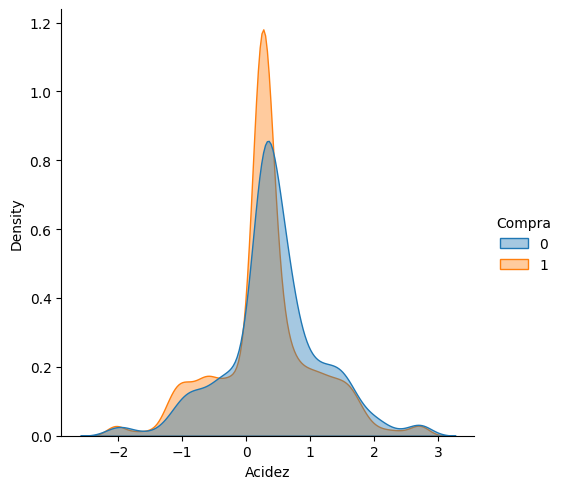

In [13]:
plt.clf()
#sns.kdeplot(vinosDep,x="Acidez", hue="Compra", fill=True, common_norm=False, alpha=0.4)
sns.displot(vinosDep, x="Acidez", hue="Compra", kind="kde",fill=True, common_norm=False, alpha=0.4)
#sns.histplot(y='CalifProductor',color='Compra',data=vinosDep,palette='viridis')
plt.show()


<Figure size 640x480 with 0 Axes>

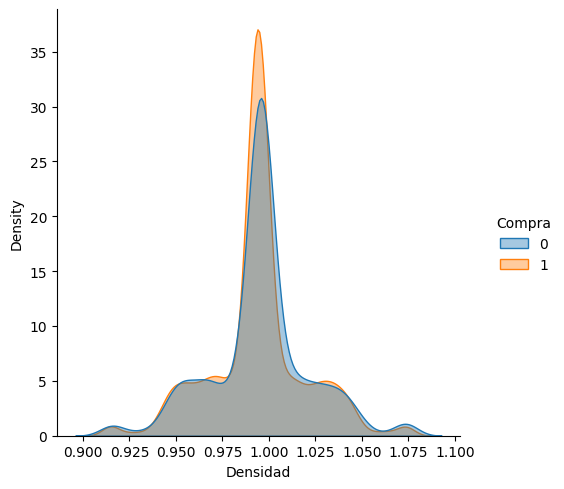

In [14]:
plt.clf()
#sns.kdeplot(vinosDep,x="Densidad", hue="Compra", fill=True, common_norm=False, alpha=0.4)
sns.displot(vinosDep, x="Densidad", hue="Compra",kind="kde",fill=True, common_norm=False, alpha=0.4)
#sns.histplot(y='CalifProductor',color='Compra',data=vinosDep,palette='viridis')
plt.show()


Por ver que V de cramer no miente, probamos con densidad y el resultado es que el solapamiento de las distribuciones de 0 y 1 es casi completa. En el caso de Acidez, existe una ligera diferencia en distribuciones que quizá se traduzca en un mínimo efecto en el modelo (se verá..)

Las variables calificación del productor continua parece tener influencia en la respuesta binaria en el sentido de que los vinos que se compran (compra=1) tienen una distribución de calificación de productor menos elevada...algo que puede resultar poco intuitivo pero, ya se sabe, el productor y sus calificaciones con posible sesgo...jeje


## Tranformaciones de variables

Vamos a generar las transformaciones de las variable continuas que maximizan la relación con la variable objetivo binaria en sentido de V de Cramer. 

**Nota:** La principal precaución que hay que tener si utilizamos el arvhivo tod_bin es no considerar un modelo completo con todas al mismo tiempo puesto que se pueden generar los problemas de colinealidad. Solamente utilizaremos el set completo de variables cuando hagamos un proceso de selección automática de variables, proceso en el cual se elegirán las que más R2 aporten al modelo. 


In [15]:
# Aplicar a las variables continuas la mejor transfromación según cramer frente a varObjBin
transf_cramer = imputDep.select_dtypes(include=np.number).apply(lambda x: mejorTransf(x,varObjBin, tipo='cramer'))
transf_cramer_names = imputDep.select_dtypes(include=np.number).apply(lambda x: mejorTransf(x,varObjBin,tipo='cramer', name=True))
transf_cramer.columns = transf_cramer_names.values
transf_cramer


Acidez_ident  AcidoCitrico_raiz4  Azucar_ident  CloruroSodico_raiz4  \
0         2.870958            1.147441      3.691366             1.120347   
1         6.092554            1.133434      3.354713             1.320109   
2         3.039832            1.220678      3.554322             1.327946   
3         1.078295            1.326782      2.955497             1.321139   
4         3.013851            1.409040      3.248951             1.304716   
...            ...                 ...           ...                  ...   
6360      3.169735            1.304629      2.982310             1.340925   
6361      3.559444            1.293802      4.519592             1.322509   
6362      3.091793            1.121000      1.647614             1.319765   
6363      2.883948            1.085651      4.016103             1.333983   
6364      3.078803            1.297894      3.223627             1.317350   

      Densidad_cuarta  pH_ident  Sulfatos_sqr  Alcohol_sqr  \
0          377.644920  3.342477     10.678068     8.582391   
1           96.376608  2.951028      9.179034    39.152855   
2           98.990307  3.508091     14.588962     8.582391   
3          440.476058  3.071474      2.262245    10.885453   
4          101.357903  5.676119      7.793324    18.201495   
...               ...       ...           ...          ...   
6360       134.863737  4.697495      6.970514     7.769400   
6361        94.568613  3.598425      8.789874     5.307768   
6362        26.289894  2.755303     23.288416    15.855578   
6363        76.879514  3.146753      8.918657    12.238811   
6364        76.234425  4.230767     10.119853     9.788527   

      CalifProductor_ident  PrecioBotella_raiz4  aleatorio_log  aleatorio2_exp  
0                  1.52642             0.100000      -3.001110        1.416389  
1                  2.28958             1.126739       0.688149        6.338755  
2                  2.28958             1.164986       1.035757        3.984875  
3                  1.52642             1.371832       0.952302       11.720824  
4                  0.76326             0.993743       1.093678        2.273390  
...                    ...                  ...            ...             ...  
6360               3.05274             0.659962       0.144580        1.481377  
6361               1.52642             1.212342       0.617006        5.547765  
6362               3.05274             0.860624       0.903356       23.756421  
6363               0.76326             0.100000       0.350608       10.375999  
6364               0.76326             1.049288       0.459898       20.123803  

[6365 rows x 12 columns]

Aquí podemos fijarnos en los cambios en VCramer al transformar las variables. Destaca el caso de la variable Azucar. En su estado natural es muy mala, en cambio con la transformación raiz4 pasa directamente al top 5 de efectos!! Esto es justamente lo que se busca con estas transformaciones. 



In [16]:
# Generar input con tranformaciones
imput_transf = imputDep.join(transf_cramer)

# Aplicar la función al input completo contra la objetivo
tablaCramer = pd.DataFrame(imput_transf.apply(lambda x: cramers_v(x,varObjBin)),columns=['VCramer'])

# Obtener el gráfico de importancia de las variables frente a la objetivo continua según vcramer
import plotly.express as px
px.bar(tablaCramer,x=tablaCramer.VCramer,title='Relaciones frente a Compra').update_yaxes(categoryorder="total ascending").show()
plt.show()

In [17]:
# Guardar archivo con transformaciones para la variable objetivo binaria
# Agregar variables objetivo al input ya limpio
todo_bin = pd.concat([imput_transf,varObjBin], axis=1)

# Guardar archivo
todo_bin.to_csv('todo_bin_Vino.csv')


# Modelos de regresión logística para la predicción de la variable compra

En esta sección se ajustan distintos modelos de regresión logística para predecir la compra de los vinos. En primer lugar, tomamos la partición training (donde ajustamos el modelo) y test (donde probamos su capacidad).

Antes de nada vamos a aclararnos con el archivo a utilizar que será el todo_bin que hemos generado, aunque en esta primera parte (por no hacerlo muy largo y pesado) nos centraremos en variables originales sin transformaciones. Es importante tener claro que queremos filtrar y como hacerlo.

Por otra parte, siempre es conveniente echar un vistazo a la distribución de la variable objetivo, cuantos 0 y 1 hay en el archivo?? Esto es muy relevante a la hora de valorar cuestiones importantes en el contexto de clasificación supervisada. En particular, prestamos atención a la baja representación del evento ya que esto supone un handicap para cualquier algoritmo de clasificación (incluida la regresión logística) y ha dado lugar a toda una rama de investigación sobre *imbalanced classification* que se agudiza en el contexto del Big Data y la paralelización de procesos con los llamados *small disjunts* que seproducen cuando en la paralelización se tienen particiones poco representativas de los datos (y del evento en particular) en los distintos nodos del cluster computacional utilizado. Todo esto para alimentar la curiosidad y dar un contexto sobre la importancia de todo esto. 

Es muy importante saber también como funcionan las métricas de evaluación en el contexto de la clasificación supervisada. Es muy extendido el uso del famoso Accuracy, lo que vendría a ser el complementario a 1 de la tasa de fallos de la matriz de confusión de las predicciones frente a la distribución original. Hablando en plata, cuanto te has equivocado Don modelo sumando 0 y 1?? 

Por supuesto, es una métrica muy válida e informativa pero tiene sus riesgos cuando nos salimos del contexto para el que fueron concebidas (distribución balanceada de clases del evento  aprox. 50% de cada una de las categorías). Imaginemos la siguiente situación, variable objetivo binaria con el 5% de las instancias pertenecientes al evento y el 95% al no evento (mortalidad en accidentes, enfermedades raras, impagos bancarios etc..). Ajustamos modelo, podría ser R. Logística o una potente red neuronal...Resultado, Accuracy del 95% has acertado en el 95% de los casos!! Apago el ordenador y me voy feliz a casa con el informe enviado a la jefa. Probablemente no vuelvo a currar más allí... 

Problema: El algoritmo lo que quiere es minimizar la tasa de fallos (si es que se consigna esa métrica para su ajuste) por lo que lo más fácil con toda probabilidad es decir que todos son *no evento* asegurando un muy buen accuracy aparente. En cuanto indagamos un poco y le preguntamos por la *sensibilidad* del modelo nos respondería 0. Es decir la capacidad de reconocer a los eventos (los 1) es nula ya que no ha identificado ninguno...el accuracy sigue siendo del 95%. 

Toda esta película motiva el siguiente check de la distribución a priori de la variable y la consiguiente decisión de la métrica a utilizar para la evaluación del modelo de clasificación. Como se verá el área bajo la curva ROC o el kappa suelen ser métricas más adecuadas cuando no se presenta balanceo de clases. 


## Comprobación de la frecuencia relativa a priori del evento en la muestra

In [18]:
# Trabajamos con el archivo con variable originales
vinosDep.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6365 entries, 0 to 6364
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ID              6365 non-null   int64   
 1   Acidez          6365 non-null   float64 
 2   AcidoCitrico    6365 non-null   float64 
 3   Azucar          6365 non-null   float64 
 4   CloruroSodico   6365 non-null   float64 
 5   Densidad        6365 non-null   float64 
 6   pH              6365 non-null   float64 
 7   Sulfatos        6365 non-null   float64 
 8   Alcohol         6365 non-null   float64 
 9   CalifProductor  6365 non-null   int64   
 10  PrecioBotella   6365 non-null   float64 
 11  Etiqueta        6365 non-null   category
 12  Clasificacion   6365 non-null   category
 13  Region          6365 non-null   category
 14  prop_missings   6365 non-null   category
 15  Beneficio       6365 non-null   int64   
 16  Compra          6365 non-null   category
 17  aleatorio       636

In [19]:
# Tabla de frecuencias relativas de las categorías de Compra
vinosDep.Compra.value_counts(normalize=True)


Compra
1    0.785232
0    0.214768
Name: proportion, dtype: float64

En este caso, tenemos la situación de desbalanceo hacia los 1 ya que la frecuencia a priori de 1 es del 78%. El modelo tendrá mayor dificultad en reconocer a los 0. Visto esto, si tenemos un accuracy de 0.78...podemos sospechar y miraremos bien *sensibilidad* y *especificidad* para tranquilizar nuestras conciencias. 



## Partición training-test

Vamos a generar la partición del archivo en el que incluiremos solamente las variables originales. Por ello, pedimos que nos muestre las posiciones de las variables para saber como filtrar las columnas deseadas. 

Tenemos que seleccionar variables originales (1:18) y la respuesta (33). 



In [20]:
# Función necesaria
from sklearn.model_selection import train_test_split

# Creamos 4 objetos: predictores para tr y tst y variable objetivo para tr y tst. 
X_train, X_test, y_train, y_test = train_test_split(imputDep, varObjBin, test_size=0.2, random_state=1234)

# Comprobamos dimensiones
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)


Training dataset shape: (5092, 16) (5092,)
Testing dataset shape: (1273, 16) (1273,)


¿ Mantendrá la proporción de clases de la variable objetivo esta partición?



In [21]:
# Training 
print(y_train.value_counts(normalize=True))

# Test
y_test.value_counts(normalize=True)


Compra
1    0.784171
0    0.215829
Name: proportion, dtype: float64


Compra
1    0.789474
0    0.210526
Name: proportion, dtype: float64

## Modelo completo de referencia

Comenzamos con nuestro modelo completo de referencia que incluye todas las variables con la precaución de no considerar ID puesto que no tiene sentido ni variables "dobladas" en el caso de que las hubiera.

En nuestro caso, no tenemos nada raro así que eliminaremos ID y tiraremos el modelo completo para valorar.

Una precaución en este punto. El método logit de *statmodels.formula.api* no acepta categórica como objetivo, por lo que transformaremos en entera.


In [22]:
# Genero el training con la objetivo dentro 
data_train = X_train.join(y_train.astype('int64'))


De nuevo, vamos a trabajar con la interfaz fórmula que resulta cómodo. Como siempre nos generamos esa función para que concatene todos los efectos del dataset en una sola fómula para evitarnos escribir mucho. 



In [23]:
# Aplicamos a fórmula de modelo completo
formC=ols_formula(data_train,'Compra')
formC


'Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region + prop_missings + aleatorio + aleatorio2'

Ya tenemos la fórmula del modelo completo. 



In [24]:
data_train

Acidez  AcidoCitrico  Azucar  CloruroSodico  Densidad    pH  Sulfatos  \
3574    0.24          0.56     4.3          0.044   0.97323  2.61      0.44   
2287    0.24          0.30   -23.3          0.035   1.04440  3.22      0.57   
5692    0.82          0.31   109.9         -0.448   0.99013  2.63      1.98   
3525    0.61          0.28     1.6          0.147   1.02338  2.15      1.06   
809     0.58         -0.37     1.3          0.338   0.99410  5.19     -1.05   
...      ...           ...     ...            ...       ...   ...       ...   
664     0.18          0.31    11.8          0.607   0.97072  3.07      0.41   
3276    0.58          0.07     6.9          0.084   0.99440  2.55      2.23   
1318    0.44          1.42     2.7         -0.107   0.99630  3.84      0.63   
723     0.24          0.20    15.8          0.447   0.97091  3.54      2.15   
2863    0.31          0.24    34.7          0.031   0.99397  3.16     -2.32   

      Alcohol  CalifProductor  PrecioBotella Etiqueta Clasificacion Region  \
3574     13.3               4           2.32        M          Desc  Reg 2   
2287      5.4               3           1.09       MB           ***  Reg 3   
5692     18.4               2           2.20       MM             *  Reg 2   
3525     14.0               3           3.07        R           ***  Reg 2   
809      20.6               3           3.75        M             *  Reg 1   
...       ...             ...            ...      ...           ...    ...   
664       2.9               4           1.51        M            **  Reg 2   
3276      9.7               1           2.04        M            **  Reg 3   
1318     11.6               6           2.92        M            **  Reg 2   
723      12.5               3           1.94        M          Desc  Reg 1   
2863      8.1               3           2.82        R             *  Reg 2   

     prop_missings  aleatorio  aleatorio2  Compra  
3574      0.000000   0.534046    0.164558       0  
2287      0.000000   0.487393    0.835532       1  
5692      0.000000   0.707211    0.045660       1  
3525      0.000000   0.910494    0.212946       1  
809       0.000000   0.615590    0.704236       1  
...            ...        ...         ...     ...  
664       7.142857   0.814265    0.444752       1  
3276      0.000000   0.843051    0.291749       1  
1318      0.000000   0.323632    0.052156       1  
723       7.142857   0.027356    0.494450       0  
2863      0.000000   0.624188    0.275967       1  

[5092 rows x 17 columns]

In [25]:
# Importamos la api para fórmulas (en concreto ols para regresión)
from statsmodels.formula.api import logit 

# Ajusto regresión de ejemplo
modeloCompleto = logit(formC,data=data_train).fit(method='bfgs')
modeloCompleto.summary()


         Current function value: 0.308392
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


C:\Users\Guille\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5066
Method:                           MLE   Df Model:                           25
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4087
Time:                        02:26:05   Log-Likelihood:                -1570.3
converged:                      False   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.9214      1.766      0.522      0.602      -2.540       4.383
Etiqueta[T.M]                           0.4057      0.203      1.996      0.046       0.007       0.804
Etiqueta[T.R]                          -0.3074      0.196     -1.566      0.117      -0.692       0.077
Etiqueta[T.B]                          -0.6018      0.213     -2.830      0.005      -1.018      -0.185
Etiqueta[T.MB]                         -0.3684      0.321     -1.149      0.251      -0.997       0.260
Clasificacion[T.*]                      1.9161      0.098     19.492      0.000       1.723       2.109
Clasificacion[T.**]                     4.3371      0.190     22.885      0.000       3.966       4.709
Clasificacion[T.***]                    5.4104      0.371     14.575      0.000       4.683       6.138
Clasificacion[T.****]                   3.9582      0.339     11.673      0.000       3.294       4.623
Region[T.Reg 2]                        -0.3171      0.112     -2.838      0.005      -0.536      -0.098
Region[T.Reg 3]                        -0.3292      0.110     -3.002      0.003      -0.544      -0.114
prop_missings[T.7.142857142857142]     -0.0431      0.105     -0.409      0.683      -0.250       0.164
prop_missings[T.14.285714285714285]    -0.3017      0.249     -1.211      0.226      -0.790       0.187
prop_missings[T.21.428571428571427]     0.0011      1.122      0.001      0.999      -2.199       2.201
Acidez                                 -0.2643      0.059     -4.479      0.000      -0.380      -0.149
AcidoCitrico                           -0.0302      0.054     -0.562      0.574      -0.135       0.075
Azucar                                  0.0018      0.001      1.311      0.190      -0.001       0.004
CloruroSodico                          -0.3776      0.143     -2.644      0.008      -0.657      -0.098
Densidad                                0.8516      1.731      0.492      0.623      -2.541       4.244
pH                                     -0.1596      0.067     -2.375      0.018      -0.291      -0.028
Sulfatos                                0.0644      0.049      1.319      0.187      -0.031       0.160
Alcohol                                -0.0075      0.013     -0.592      0.554      -0.032       0.017
CalifProductor                         -0.4090      0.034    -11.931      0.000      -0.476      -0.342
PrecioBotella                           0.0541      0.030      1.790      0.073      -0.005       0.113
aleatorio                              -0.1618      0.153     -1.056      0.291      -0.462       0.138
aleatorio2                             -0.1528      0.153     -1.001      0.317      -0.452       0.146
=======================================================================================================
"""

Salta a la vista que hay muchos efectos no significativos (no tienen estrellas) y a primera vista mosquean los errores gigantes clasificación *** y ****. Atención porque el parámetro estimado de 20 o 22 resulta el mayor de todos... Vale, a que se debe esto?? Con toda probabilidad a la falta de instancias de estas categorías con compra = 0. Recordemos que la incidencia era ya baja y hemos tomado una partición de los datos..lo que empeora la situación. 

Vamos a echar un ojo a la distribución de la tabla cruzada de Clasificación y la objetivo en data_train. 


In [26]:
pd.crosstab(data_train.Compra, data_train.Clasificacion)



Clasificacion  Desc    *    **  ***  ****
Compra                                   
0               810  250    39    0     0
1               526  971  1375  862   259

Vaya...ni una sola instancia con compra=0 y clasificación de *** o ****. Esto genera ese alto error. El gran problema de esto será la interpretabilidad del modelo. Hay que pensar que el OR (cuanto más probable es que se de el evento que el no evento dada una premisa) es la exponencial del parámetro..si este parámetro es 20, estamos ante un OR de 485165195, cosa que resulta difícil de interpretar. Por este motivo y dado que uno de los puntos fuertes de las regresiones es la interpretación, decidimos unir categorías. 



In [27]:
# Unimos la categorías problemáticas de Clasificacion
imputDep.Clasificacion.replace(['**','***','****'],'**+',inplace=True)


# Actualizar la partición
X_train, X_test, y_train, y_test = train_test_split(imputDep, varObjBin, test_size=0.2, random_state=1234)

# Genero el training con la objetivo dentro 
data_train = X_train.join(y_train.astype('int64'))
data_test = X_test.join(y_test.astype('int64'))

# Volver a ajustar el modelo inicial
modeloCompleto = logit(formC,data=data_train).fit()
modeloCompleto.summary()


# Volver a ajustar el modelo inicial en test para valorar pseudo R2
# modeloCompleto = logit(formC,data=data_test).fit()
# modeloCompleto.summary()


Optimization terminated successfully.
         Current function value: 0.305182
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5068
Method:                           MLE   Df Model:                           23
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4149
Time:                        02:26:05   Log-Likelihood:                -1554.0
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               4.0228      1.781      2.259      0.024       0.532       7.514
Etiqueta[T.M]                          -0.3638      0.219     -1.662      0.097      -0.793       0.065
Etiqueta[T.R]                          -1.0192      0.213     -4.776      0.000      -1.437      -0.601
Etiqueta[T.B]                          -1.3973      0.229     -6.107      0.000      -1.846      -0.949
Etiqueta[T.MB]                         -1.7917      0.331     -5.408      0.000      -2.441      -1.142
Clasificacion[T.*]                      1.8008      0.097     18.503      0.000       1.610       1.992
Clasificacion[T.**+]                    4.8288      0.179     27.017      0.000       4.479       5.179
Region[T.Reg 2]                        -0.1017      0.112     -0.908      0.364      -0.321       0.118
Region[T.Reg 3]                        -0.1247      0.110     -1.134      0.257      -0.340       0.091
prop_missings[T.7.142857142857142]     -0.1553      0.106     -1.468      0.142      -0.363       0.052
prop_missings[T.14.285714285714285]    -0.4103      0.253     -1.620      0.105      -0.907       0.086
prop_missings[T.21.428571428571427]     0.1415      1.143      0.124      0.901      -2.098       2.381
Acidez                                 -0.1780      0.059     -3.000      0.003      -0.294      -0.062
AcidoCitrico                            0.0090      0.054      0.167      0.867      -0.097       0.115
Azucar                                  0.0020      0.001      1.473      0.141      -0.001       0.005
CloruroSodico                          -0.3966      0.144     -2.754      0.006      -0.679      -0.114
Densidad                               -1.3889      1.742     -0.797      0.425      -4.804       2.026
pH                                     -0.2429      0.068     -3.582      0.000      -0.376      -0.110
Sulfatos                               -0.0479      0.049     -0.974      0.330      -0.144       0.048
Alcohol                                -0.0162      0.013     -1.269      0.205      -0.041       0.009
CalifProductor                         -0.4183      0.035    -12.025      0.000      -0.487      -0.350
PrecioBotella                           0.0321      0.030      1.058      0.290      -0.027       0.092
aleatorio                               0.1054      0.154      0.683      0.494      -0.197       0.408
aleatorio2                              0.0791      0.154      0.514      0.607      -0.222       0.381
=======================================================================================================
"""

In [28]:
# Volver a ajustar el modelo inicial
modeloEti= logit('Compra~Etiqueta+Clasificacion',data=data_train).fit()
modeloEti.summary()

Optimization terminated successfully.
         Current function value: 0.325890
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5085
Method:                           MLE   Df Model:                            6
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.3752
Time:                        02:26:05   Log-Likelihood:                -1659.4
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3894      0.196      1.987      0.047       0.005       0.774
Etiqueta[T.M]           -0.3264      0.210     -1.551      0.121      -0.739       0.086
Etiqueta[T.R]           -1.0025      0.205     -4.886      0.000      -1.405      -0.600
Etiqueta[T.B]           -1.4218      0.219     -6.486      0.000      -1.851      -0.992
Etiqueta[T.MB]          -1.7830      0.324     -5.505      0.000      -2.418      -1.148
Clasificacion[T.*]       1.8148      0.093     19.529      0.000       1.633       1.997
Clasificacion[T.**+]     4.8798      0.176     27.741      0.000       4.535       5.225
========================================================================================
"""

Nos hemos librado de los peligros de OR gigantes!!

Consultamos los valores de pseudoR2 en los conjuntos de training y test, que se sitúan en torno a 0.41 lo cual indica un muy buen ajuste. Recordemos que puede equivaler a R2 lineales de más de 0.8!!


## Importancia de las variables

Siguiendo los mismo pasos que en Regresión Lineal, podemos consultar la importancia de vairiables en el modelo utilizando la función relativeImp. La precaución, como entonces, es que necesitamos las matrices de diseño explícitas con las categorícas extendidas a dummies, y para esto utilizamos pasty.


In [29]:
import statsmodels.api as sm
import patsy

# Generamos las matrices de diseño según la fórmula de modelo completo
y_tr, X_tr = patsy.dmatrices(formC, data_train, return_type='dataframe')

# Generamos las matrices de diseño según la fórmula de modelo completo para test
y_tst, X_tst = patsy.dmatrices(formC, data_test, return_type='dataframe')


# Ahora podemos aplicar la función "oficial" de statmodels Logit (con formato y,X)
# model=sm.Logit(y,X).fit()
# model.summary()


Calculamos la importancia relativa de los efectos del modelo.



In [30]:
from relativeImp import relativeImp

# Nombres de predictores (en modo dummy) donde quitamos la constante
names=X_tr.columns.tolist()[1:]

# Calculamos importancia relativa
df_results = relativeImp(X_tr.join(y_tr), outcomeName = 'Compra', driverNames = names)

# Ordenamos valores 
df_results.sort_values(by='normRelaImpt', ascending=False)


driver  rawRelaImpt  normRelaImpt
5                  Clasificacion[T.**+]     0.276264     68.557999
4                    Clasificacion[T.*]     0.054219     13.455159
19                       CalifProductor     0.052932     13.135577
2                         Etiqueta[T.B]     0.004160      1.032422
11                               Acidez     0.003322      0.824457
1                         Etiqueta[T.R]     0.001992      0.494345
0                         Etiqueta[T.M]     0.001850      0.459075
14                        CloruroSodico     0.001798      0.446256
3                        Etiqueta[T.MB]     0.001481      0.367451
16                                   pH     0.001425      0.353581
9   prop_missings[T.14.285714285714285]     0.000835      0.207252
13                               Azucar     0.000670      0.166357
17                             Sulfatos     0.000667      0.165482
8    prop_missings[T.7.142857142857142]     0.000522      0.129430
15                             Densidad     0.000203      0.050336
18                              Alcohol     0.000167      0.041369
6                       Region[T.Reg 2]     0.000113      0.027981
21                            aleatorio     0.000089      0.021970
12                         AcidoCitrico     0.000088      0.021820
20                        PrecioBotella     0.000082      0.020302
7                       Region[T.Reg 3]     0.000059      0.014701
10  prop_missings[T.21.428571428571427]     0.000020      0.004880
22                           aleatorio2     0.000007      0.001797

## Métricas de ajuste en training-test

Recurrimos a sklearn para obtener todo tipo de métricas de evaluación para el modelo logístico. 


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Definición de modelo
modelo = LogisticRegression(solver='lbfgs', max_iter=1000, penalty=None)

# Arreglar y para que le guste a sklearn...numeric
y_tr_ = y_tr.Compra.ravel()

# Ajuste de modelo
modelLog = modelo.fit(X_tr,y_tr_)

# Accuracy del modelo en training
acc = modelLog.score(X_tr,y_tr_)
print(acc)

# Predicciones en test
y_pred = modelLog.predict(X_tst)

# Matriz de confusion de clasificación 
print(metrics.confusion_matrix(y_tst,y_pred))

# Reporte de clasificación 
print(metrics.classification_report(y_tst,y_pred))

# Extraemos el Area bajo la curva ROC
metrics.roc_auc_score(y_tr, modelLog.predict_proba(X_tr)[:, 1])


0.8605655930871956
[[176  92]
 [ 87 918]]
              precision    recall  f1-score   support

         0.0       0.67      0.66      0.66       268
         1.0       0.91      0.91      0.91      1005

    accuracy                           0.86      1273
   macro avg       0.79      0.79      0.79      1273
weighted avg       0.86      0.86      0.86      1273



0.9050476641675252

## Proceso manual hacia delante

Vamos a considerar un modelo con las 3 primeras variables ya que presentan una importancia bastante más elevada que el resto.


In [32]:
form1 = 'Compra ~ Clasificacion + CalifProductor + pH'

# Ajustar modelo 1
modelo1 = logit(form1,data=data_train).fit()
modelo1.summary()


Optimization terminated successfully.
         Current function value: 0.317586
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5087
Method:                           MLE   Df Model:                            4
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.3911
Time:                        02:26:05   Log-Likelihood:                -1617.1
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.6466      0.247      6.659      0.000       1.162       2.131
Clasificacion[T.*]       1.7685      0.094     18.815      0.000       1.584       1.953
Clasificacion[T.**+]     4.5542      0.173     26.297      0.000       4.215       4.894
CalifProductor          -0.4380      0.034    -12.970      0.000      -0.504      -0.372
pH                      -0.2441      0.066     -3.700      0.000      -0.373      -0.115
========================================================================================
"""

Este modelo es sencillo y bastante significativo en cuanto a sus parámetros (muy estrellado). Por otro lado el pseudoR2 en training baja un poquito pero aumenta en test, lo que puede indicar mayor capacidad de generalización a datos desconocidos. Tiene buena pinta, habrá que probarlo en validación cruzada ya que en el esquema training/test aún estamos expuestos a la aleatoriedad de la selección de la partición.

No es mala idea probar alguna interacción de alguna de estas variables ya que tienen un caracter inherente muy similar de valoración de la calidad en algún sentido. Es lógico pensar que puedan presentar un comportamiento conjunto. Cuando incluimos interacción permitimos la evolución conjunta de las variables en el modelo, ya que de lo contrario siempre tenemos efectos independientes e interpretación ceteris paribus (a todo lo demás constante).

Probaremos entonces la interacción de clasificación y etiqueta.


In [33]:
form2 = 'Compra ~ Clasificacion*Etiqueta + CalifProductor + pH'

# Ajustar modelo 1
modelo2 = logit(form2,data=data_train).fit()
modelo2.summary()


Optimization terminated successfully.
         Current function value: 0.303252
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5075
Method:                           MLE   Df Model:                           16
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4186
Time:                        02:26:05   Log-Likelihood:                -1544.2
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.5716      0.352      7.314      0.000       1.883       3.261
Clasificacion[T.*]                      1.4915      0.418      3.564      0.000       0.671       2.312
Clasificacion[T.**+]                    2.6971      1.050      2.568      0.010       0.639       4.756
Etiqueta[T.M]                          -0.3643      0.266     -1.368      0.171      -0.886       0.158
Etiqueta[T.R]                          -1.1020      0.262     -4.203      0.000      -1.616      -0.588
Etiqueta[T.B]                          -1.9344      0.295     -6.548      0.000      -2.513      -1.355
Etiqueta[T.MB]                         -1.8484      0.458     -4.032      0.000      -2.747      -0.950
Clasificacion[T.*]:Etiqueta[T.M]        0.2155      0.458      0.470      0.638      -0.682       1.113
Clasificacion[T.**+]:Etiqueta[T.M]      0.4673      1.086      0.430      0.667      -1.662       2.597
Clasificacion[T.*]:Etiqueta[T.R]        0.2156      0.441      0.489      0.625      -0.648       1.079
Clasificacion[T.**+]:Etiqueta[T.R]      2.1658      1.086      1.994      0.046       0.037       4.295
Clasificacion[T.*]:Etiqueta[T.B]        0.9890      0.485      2.040      0.041       0.039       1.939
Clasificacion[T.**+]:Etiqueta[T.B]      3.5129      1.140      3.081      0.002       1.278       5.747
Clasificacion[T.*]:Etiqueta[T.MB]      -0.3131      0.729     -0.430      0.667      -1.741       1.115
Clasificacion[T.**+]:Etiqueta[T.MB]     3.4318      1.504      2.281      0.023       0.483       6.380
CalifProductor                         -0.4236      0.035    -12.224      0.000      -0.492      -0.356
pH                                     -0.2492      0.068     -3.684      0.000      -0.382      -0.117
=======================================================================================================
"""

Modelo que no tiene mala pinta puesto que varias de las interacciones resultan significativas, algunas bastante con 2 y 3 estrellas. Normalmente no ha de asustar que algunas de ellas no sean significativas y se mantienen sin problema en el modelo. Parece producirse un efecto potenciador de la variable clasificación ya que sus coeficientes de efectos principales aumentan. En este momento el efecto de la categoría clasificación 2+ estrellas ya no solamente se valora con un único coeficiente sino con todos los implicados en la interacción con etiqueta que resulten significativos. De esta forma se hace dependiente la influencia de la clasificación a los valores que tome etiqueta. Ejemplos:

- Vinos con Clasificación 2+ estrellas 
    * Si etiqueta es B (nivel de referencia de Etiqueta), su coeficiente es 3.69 con lo que la probabilidad de compra de este tipo de vinos es exp(3.69) veces superior a aquellos vinos con clasificación 1 estrella y etiqueta B.
    * Si etiqueta es M, su coeficiente será 3.69+0.77-2.29, es decir, betaClas2estr + betaEtiM + betaClas2estr:EtiM. Con lo que el efecto será exp(3.69+0.77-2.29)=exp(2.17), menor que el anterior. ASí la probabilidad de compra de un vino con clasificación 2 estrellas y etiqueta mala es exp(2.17) mayor que la de un vino con clasificación 1 estrella y etiqueta B (niveles de referencia de ambas variables)
    
Esta es la idea de las interacciones. Como se intuye la interpretación se complica bastante pero se pueden captar patrones de realidades interesantes sin la constricción del ceteris paribus. 

Vamos a probar a eliminar esta interacción y poner en su lugar un par de variables continuas para obtener un modelo más sencillo y evaluar posteriormente si el aumenta en complejidad de las interacciones merece el esfuerzo.


In [34]:
form3 = 'Compra ~  Clasificacion + CalifProductor + pH + Etiqueta'

# Ajustar modelo 1
modelo3 = logit(form3,data=data_train).fit()
modelo3.summary()


Optimization terminated successfully.
         Current function value: 0.308137
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5083
Method:                           MLE   Df Model:                            8
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4092
Time:                        02:26:05   Log-Likelihood:                -1569.0
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4348      0.320      7.609      0.000       1.808       3.062
Clasificacion[T.*]       1.7977      0.096     18.644      0.000       1.609       1.987
Clasificacion[T.**+]     4.8221      0.178     27.090      0.000       4.473       5.171
Etiqueta[T.M]           -0.3499      0.218     -1.607      0.108      -0.777       0.077
Etiqueta[T.R]           -1.0030      0.212     -4.728      0.000      -1.419      -0.587
Etiqueta[T.B]           -1.3736      0.227     -6.042      0.000      -1.819      -0.928
Etiqueta[T.MB]          -1.7441      0.330     -5.288      0.000      -2.391      -1.098
CalifProductor          -0.4277      0.034    -12.422      0.000      -0.495      -0.360
pH                      -0.2446      0.067     -3.641      0.000      -0.376      -0.113
========================================================================================
"""

El modelo tiene la mitad de parámetros que el anterior y su capacidad en el esquema training/test es muy parecida. De hecho se observa un ligero aumento en pseudoR2 de test.

Vamos a introducir otro par de variables continuas de las que pueden influir para valorar el aporte a la capacidad predictiva del modelo y la significación estadística de estos posibles efectos.


In [35]:
form4 = 'Compra ~  Clasificacion + CalifProductor + pH + Etiqueta + CloruroSodico'

# Ajustar modelo 1
modelo4 = logit(form4,data=data_train).fit()
modelo4.summary()


Optimization terminated successfully.
         Current function value: 0.307424
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5082
Method:                           MLE   Df Model:                            9
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4106
Time:                        02:26:05   Log-Likelihood:                -1565.4
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4460      0.320      7.645      0.000       1.819       3.073
Clasificacion[T.*]       1.7987      0.097     18.630      0.000       1.609       1.988
Clasificacion[T.**+]     4.8252      0.178     27.086      0.000       4.476       5.174
Etiqueta[T.M]           -0.3416      0.218     -1.566      0.117      -0.769       0.086
Etiqueta[T.R]           -0.9935      0.212     -4.676      0.000      -1.410      -0.577
Etiqueta[T.B]           -1.3639      0.228     -5.990      0.000      -1.810      -0.918
Etiqueta[T.MB]          -1.7391      0.330     -5.262      0.000      -2.387      -1.091
CalifProductor          -0.4237      0.034    -12.299      0.000      -0.491      -0.356
pH                      -0.2479      0.067     -3.688      0.000      -0.380      -0.116
CloruroSodico           -0.3846      0.143     -2.688      0.007      -0.665      -0.104
========================================================================================
"""

A la luz del summary del modelo, ambas variables presentan algo de significación estadística en el contraste de los parámetros (lo que viene a decir que estos parámetros son distintos de 0 a un nivel de confianza del 5% con 1 estrella o al 10% con un punto). Sin embargo, no queda muy claro que aporten mucha capacidad predictiva al modelo puesto que los pseudoR2 son muy similares a los arrojados por el modelo anterior, incluso disminuye en el conjunto de test. 

Por último vamos a probar a introducir la interacción en el último modelo. Modelo más complejo para comparar por CV.


In [36]:
form5 = 'Compra ~  Clasificacion + CalifProductor + pH + Etiqueta + Acidez'

# Ajustar modelo 1
modelo5 = logit(form5,data=data_train).fit()
modelo5.summary()


Optimization terminated successfully.
         Current function value: 0.307255
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5082
Method:                           MLE   Df Model:                            9
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4109
Time:                        02:26:05   Log-Likelihood:                -1564.5
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4660      0.321      7.682      0.000       1.837       3.095
Clasificacion[T.*]       1.7981      0.097     18.609      0.000       1.609       1.988
Clasificacion[T.**+]     4.8130      0.178     27.050      0.000       4.464       5.162
Etiqueta[T.M]           -0.3527      0.218     -1.617      0.106      -0.780       0.075
Etiqueta[T.R]           -1.0001      0.212     -4.707      0.000      -1.417      -0.584
Etiqueta[T.B]           -1.3838      0.228     -6.078      0.000      -1.830      -0.938
Etiqueta[T.MB]          -1.7522      0.330     -5.308      0.000      -2.399      -1.105
CalifProductor          -0.4227      0.035    -12.248      0.000      -0.490      -0.355
pH                      -0.2374      0.067     -3.519      0.000      -0.370      -0.105
Acidez                  -0.1763      0.059     -2.988      0.003      -0.292      -0.061
========================================================================================
"""

In [37]:
form6 = 'Compra ~  Clasificacion*Etiqueta + CalifProductor + pH + CloruroSodico + Acidez'

# Ajustar modelo 6
modelo6 = logit(form6,data=data_train).fit()
modelo6.summary()


Optimization terminated successfully.
         Current function value: 0.301624
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5073
Method:                           MLE   Df Model:                           18
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4217
Time:                        02:26:05   Log-Likelihood:                -1535.9
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               2.6022      0.353      7.372      0.000       1.910       3.294
Clasificacion[T.*]                      1.5237      0.420      3.626      0.000       0.700       2.347
Clasificacion[T.**+]                    2.7607      1.051      2.627      0.009       0.701       4.820
Etiqueta[T.M]                          -0.3566      0.268     -1.331      0.183      -0.882       0.168
Etiqueta[T.R]                          -1.0715      0.264     -4.062      0.000      -1.589      -0.554
Etiqueta[T.B]                          -1.9328      0.297     -6.509      0.000      -2.515      -1.351
Etiqueta[T.MB]                         -1.8241      0.459     -3.975      0.000      -2.724      -0.925
Clasificacion[T.*]:Etiqueta[T.M]        0.2082      0.460      0.453      0.651      -0.693       1.109
Clasificacion[T.**+]:Etiqueta[T.M]      0.4320      1.087      0.397      0.691      -1.698       2.562
Clasificacion[T.*]:Etiqueta[T.R]        0.1668      0.443      0.377      0.706      -0.701       1.034
Clasificacion[T.**+]:Etiqueta[T.R]      2.0755      1.087      1.910      0.056      -0.055       4.206
Clasificacion[T.*]:Etiqueta[T.B]        0.9700      0.486      1.994      0.046       0.017       1.923
Clasificacion[T.**+]:Etiqueta[T.B]      3.4552      1.141      3.029      0.002       1.220       5.691
Clasificacion[T.*]:Etiqueta[T.MB]      -0.3986      0.731     -0.545      0.586      -1.831       1.034
Clasificacion[T.**+]:Etiqueta[T.MB]     3.3543      1.505      2.229      0.026       0.405       6.303
CalifProductor                         -0.4139      0.035    -11.900      0.000      -0.482      -0.346
pH                                     -0.2442      0.068     -3.595      0.000      -0.377      -0.111
CloruroSodico                          -0.4050      0.145     -2.796      0.005      -0.689      -0.121
Acidez                                 -0.1806      0.060     -3.033      0.002      -0.297      -0.064
=======================================================================================================
"""

In [38]:
form7 = 'Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region'

# Ajustar modelo 7
modelo7 = logit(form7,data=data_train).fit()
modelo7.summary()


Optimization terminated successfully.
         Current function value: 0.305685
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5073
Method:                           MLE   Df Model:                           18
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4139
Time:                        02:26:05   Log-Likelihood:                -1556.6
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.9817      1.777      2.241      0.025       0.500       7.464
Etiqueta[T.M]           -0.3407      0.218     -1.559      0.119      -0.769       0.088
Etiqueta[T.R]           -0.9982      0.213     -4.687      0.000      -1.416      -0.581
Etiqueta[T.B]           -1.3734      0.228     -6.019      0.000      -1.821      -0.926
Etiqueta[T.MB]          -1.7555      0.331     -5.304      0.000      -2.404      -1.107
Clasificacion[T.*]       1.8063      0.097     18.591      0.000       1.616       1.997
Clasificacion[T.**+]     4.8290      0.179     27.049      0.000       4.479       5.179
Region[T.Reg 2]         -0.0924      0.112     -0.827      0.408      -0.311       0.127
Region[T.Reg 3]         -0.1137      0.110     -1.036      0.300      -0.329       0.101
Acidez                  -0.1791      0.059     -3.025      0.002      -0.295      -0.063
AcidoCitrico             0.0103      0.054      0.192      0.848      -0.095       0.116
Azucar                   0.0021      0.001      1.524      0.127      -0.001       0.005
CloruroSodico           -0.3902      0.144     -2.713      0.007      -0.672      -0.108
Densidad                -1.3345      1.742     -0.766      0.444      -4.749       2.080
pH                      -0.2433      0.068     -3.594      0.000      -0.376      -0.111
Sulfatos                -0.0451      0.049     -0.918      0.359      -0.141       0.051
Alcohol                 -0.0171      0.013     -1.340      0.180      -0.042       0.008
CalifProductor          -0.4175      0.035    -12.016      0.000      -0.486      -0.349
PrecioBotella            0.0337      0.030      1.112      0.266      -0.026       0.093
========================================================================================
"""

De esta forma podríamos seguir jugando con los efectos y añadir interacciones u otras variables no consideradas en busca de patrones conjuntos interesantes. 


# Evaluación de los modelos por validación cruzada repetida

Pasamos a la evaluación de la capacidad de los modelos el formato comparativo y bajo el paradigma de validación cruzada repetida. ASí, partiremos el data todo en 5 partes y formaremos 5 training con las 5 combinaciones de 4/5 con sus correspondientes 5 test de 1/5, repitiendo esto 20 veces con distintas semillas de inicialización de las particiones. De esta forma, el modelo (misma fórmula) se enfrentará a distintos tr/tst considerando en su entrenamiento todos los datos finalmente pero nunca todos a la vez, evitando sobreajuste y la sombra de la aleatoriedad. Tendremos 100 ajustes por fórmula y promediaremos los resultados obtenidos para valorar la relación sesgo-varianza.

Hay un pequeño truquillo en este punto para que caret y su función train (maravilla del ML en R) reconozca la variable objetivo como le gusta, esto es, con nombres de factor y no 0 y 1 (los genios tienen sus cositas..) Para ello existe la opción make.names() que realiza este paso y nombre como X0 y X1. Antes de esto, haremos una copia de nuestra variable 0,1 porque nos gustará mantenerla así para otras cuestiones. 

Una vez hecho esto, generamos una lista de fórmulas de los modelos creados y aplicamos un bucle para que se aplique la función train a cada fórmula con el esquema comentado. Como comentábamos en algún punto, dado el desbalanceo de clases en la objetivo, utilizaremos la métrica ROC para evaluar la bondad de ajuste y no el accuracy. 

Tras este proceso obtenemos un boxplot con el sesgo-varianza de las métricas de ajuste a lo largo de los 100 modelos por fórmula. 


El boxplot muestra el sesgo-varianza de las estimaciones por validación cruzada para todos nuestros modelos, comenzando por el modelo completo, modelo con las 3 nominales, modelo con la interacción, luego con las dos primeras continuas, luego la adición de otras dos continuas y finalmente el modelo con las 4 continuas y la interacción. 

En general todos son modelos buenos puesto que tienen un valor de ROC en torno a 0.9, lo que indica una capacidad de clasificación muy buena. Las diferencias entre ellos son muy sutiles (por la escala del gráfico parecen mayores..)

Veamos los valores medios y la desviación respecto a la media de todos los modelos para valorar numéricamente estas diferencias.


In [39]:
# Arreglar variable objetivo como numeric (ya sabemos sklearn..)
vinosDep.Compra = vinosDep.Compra.astype('int64')

# Aplicacion a una fórmula
cross_val_log(form7,data=vinosDep)


Modelo: Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region
AUC: 0.908 (0.007)


array([0.89690112, 0.91697435, 0.91145055, 0.91403663, 0.90319184,
       0.91859782, 0.90882932, 0.91186901, 0.89669963, 0.90488645,
       0.90649708, 0.91019165, 0.90844837, 0.90218434, 0.91467145,
       0.91372711, 0.89689722, 0.90544741, 0.91383616, 0.91008927,
       0.90578196, 0.90185786, 0.90692308, 0.91383089, 0.91362961,
       0.89868875, 0.91088856, 0.90808223, 0.91279966, 0.91089052,
       0.90972882, 0.90765574, 0.89711247, 0.90967511, 0.91822569,
       0.91121548, 0.91031323, 0.91111391, 0.90261727, 0.90777117,
       0.91055707, 0.91277409, 0.91884953, 0.91427302, 0.88692441,
       0.91254136, 0.91365088, 0.90560208, 0.90665371, 0.90251776,
       0.91688638, 0.91269468, 0.90288025, 0.89978272, 0.90974802,
       0.89988744, 0.90509624, 0.90043052, 0.91991974, 0.91686053,
       0.90571789, 0.91083251, 0.90635209, 0.90625391, 0.9141597 ,
       0.91175442, 0.89817518, 0.90473666, 0.90568623, 0.91824815,
       0.90365939, 0.91192287, 0.91197088, 0.90958465, 0.90330

Creamos lista de fórmulas y aplicamos de froma general la comparativa por CV.



In [40]:
# Unimos la categorías problemáticas de Clasificacion
vinosDep.Clasificacion.replace(['**','***','****'],'**+',inplace=True)


# Creamos lista de fórmulas   
list_form = [formC,form1,form2,form3,form4,form5,form6,form7]
#list_form


# Aplicamos a toda la lista la función creada (devuelve un dataframe pero está transpuesto)
list_res = pd.DataFrame(map(lambda x: cross_val_log(x,vinosDep, seed=2022),list_form))


Modelo: Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region + prop_missings + aleatorio + aleatorio2
AUC: 0.903 (0.008)
Modelo: Compra ~ Clasificacion + CalifProductor + pH
AUC: 0.898 (0.008)
Modelo: Compra ~ Clasificacion*Etiqueta + CalifProductor + pH
AUC: 0.907 (0.007)
Modelo: Compra ~  Clasificacion + CalifProductor + pH + Etiqueta
AUC: 0.903 (0.008)
Modelo: Compra ~  Clasificacion + CalifProductor + pH + Etiqueta + CloruroSodico
AUC: 0.904 (0.008)
Modelo: Compra ~  Clasificacion + CalifProductor + pH + Etiqueta + Acidez
AUC: 0.904 (0.008)
Modelo: Compra ~  Clasificacion*Etiqueta + CalifProductor + pH + CloruroSodico + Acidez
AUC: 0.908 (0.007)
Modelo: Compra ~ Acidez + AcidoCitrico + Azucar + CloruroSodico + Densidad + pH + Sulfatos + Alcohol + CalifProductor + PrecioBotella + Etiqueta + Clasificacion + Region
AUC: 0.904 (0.008)


Arreglamos el dataset resultante para poder pintar con facilidad.



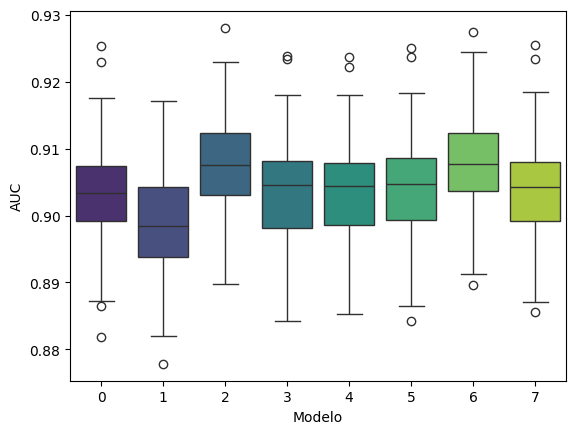

In [41]:
# Transponer dataframe y pasar de wide a long (creando un factor variable con el nombre de cada fórmula de la lista[0,1,2,3])
results = list_res.T.melt()
results.columns = ['Modelo','AUC']
results.head()

# Boxplot paralelo para comparar
plt.clf()
sns.boxplot(x='Modelo',y='AUC',data=results,palette='viridis')
plt.show()


Todos son buenos modelos puesto que tienen un ROC de 0.9. Entre ellos las diferencias son muy muy ligeras por lo que la decisión final dependerá de la complejidad de los mismos. Siempre será tentador optar por los mejores (en milésimas) como los modelos que tienen las interacciones de Clasificación y Etiqueta (esto se debe a la escala del boxplot porque si el eje empezara en 0 ni notaríamos la diferencia probablemente). 

No me parece mala idea ir a modelo más complejo pero, una vez valorado (ajustado en modelo completo y evaluados los OR) la interacción pierde significación estadística y los OR por tanto, también. Es por ello que me decido por el modelo **form3** que es el que resulta más sencillo y con capacidad predictiva muy similar a los demás. 

Todo esto no lo creáis, podéis probar a lanzar los siguientes códigos con otro modelo...



# Punto de corte óptimo para la probabilidad estimada

Vamos a ver las distribuciones de las probabilidades estimadas para los conjuntos de evento y no evento observado. Lo que nos gustaría es tener una separabilidad total, es decir 0 solapamiento e, idealmente, que las probabilidades estimadas para los 0 fueran muy bajas (se concentraran en valores pequeños) y las de los 1 contrariamente en valores altos cercanos a 1.


In [42]:
metrics.get_scorer_names()



['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 '

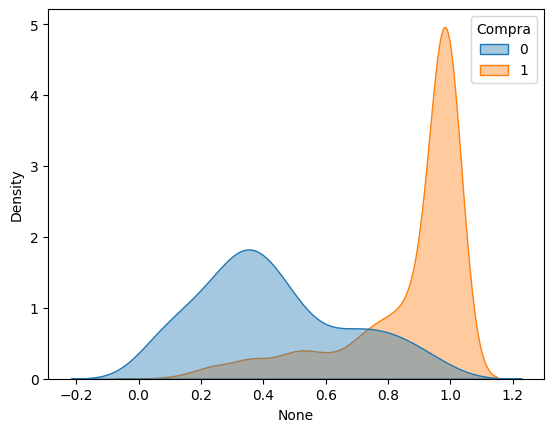

In [43]:
## Buscamos el mejor punto de corte

y_pred = modelo3.predict(X_test)

#sns.histplot(x=y_pred, hue=y_test)
#px.histogram(x=y_pred, color=y_test).show()
#gráfico de las probabilidades obtenidas
plt.clf()
sns.kdeplot(x=y_pred, hue=y_test, fill=True, common_norm=False, alpha=0.4)
plt.show()
#hist_targetbinaria(predict(modelo4, newdata=data_test,type="response"),data_test$varObjBin,"probabilidad")


In [44]:
y_pred.describe()

count    1273.000000
mean        0.772867
std         0.274231
min         0.015858
25%         0.572663
50%         0.924237
75%         0.986845
max         0.998230
dtype: float64

En naranja la distribución de probabilidades estimadas para los 1. Muy buena pinta, su densidad se "apunta" en valores altos. Sin embargo la de los 0 está mucho más repartida..Recordemos que dado el desbalanceo ya intuíamos que el modelo tendría mayor dificultad en reconocer a los 0. 

En cualquier caso parece que se puede conseguir una separabilidad alta entre clases con algún punto de corte de la probabilidad, esto es, diciendo todas las probabilidades estimadas mayores que punto de corte los clasifico como 1 y el resto como 0. 

El valor de corte por defecto en cualquier algoritmo de clasificación es el 0.5 pero esto no necesariamente es lo más adecuado en contexto de desbalanceo. Por esta razón es bueno hacer el ejercicio de buscar el punto de corte que resulte óptimo bajo algún criterio. 

En primer lugar vamos a ir a "ojímetro" dado el gráfico anterior. Probaremos el estándar 0.5 y otro punto de corte que parece que discrimina bien, en este caso parece que en el entorno de 0.75 es donde comienza a aumentar mucho la probabilidad de 1 y disminuye la de 0. Probaremos por ahí...(siempre hay que tener en cuenta la pre valencia a priori del evento, es decir, su frecuencia relativa de aparición en el archivo que era 0.78)


Gráfico de curva ROC.


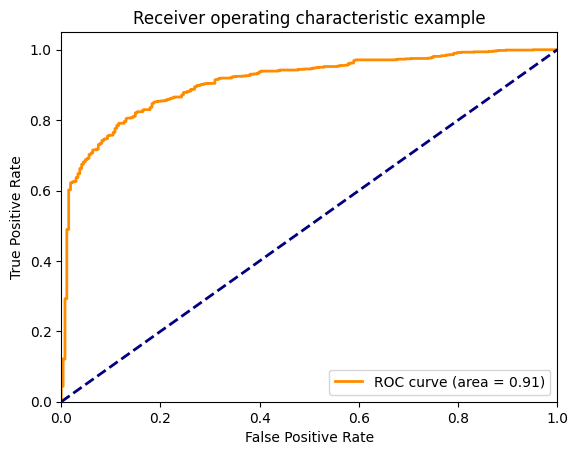

In [45]:
def roc_grafico(test,pred): 
    fpr, tpr, thresholds = metrics.roc_curve(test,pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    
roc_grafico(y_test,y_pred)


Vale, aquí los resultados. Con el punto de corte en 0.5 el accuracy es 0.85 (85% de individuos correctamente clasificados) ahora bien, la especificidad (capacidad para clasificar a los 0) está en un 61.9% con lo que se está comentiendo casi un 40% de falsos positivos, individuos que el modelo clasifica como 1 pero en verdad son 0... Este valor es muy bajo..pobres 0...

Con el punto de corte en 0.75, el accuracy disminuye un poco (algo natural puesto que no se puede maximizar todo a la vez) pero la especificidad aumenta a 0.85, solamente un 15% de falsos positivos. Se sacrifica sin embargo la sensibilidad (capacidad de clasificar a los 1) pasando de 0.91 a 0.82. 

Este es el clásico trade-off entre sensibilidad y especificidad y la decisión depende mucho del contexto. Hay aplicaciones donde el coste de cometer un falso positivo es muchísimo mayor (porque se le aplica un tratamiento o prueba gold standard carísima) por lo que se tiende a minimizar este riesgo. En otras ocasiones queremos reconocer a todos los 1 seguro puesto que puede ser cuestión de vida o muerte y no nos importa tanto si se cuelan algunos 0..

Existe el índice de youden que maximiza la relación entre sensibilidad y especificidad conjuntamente con una simple fórmula aditiva, sens+espec-1. 

Podemos generar una rejilla de puntos de corte posibles entre 0 y 1 y valorar cual de los maximiza este criterio y compararlo con el que maximiza el accuracy. 


In [46]:
# Aplicar corte de youden (NuestrasFunciones)
corte = cutoff_youden(y_test,y_pred)
corte


0.7630305646879421

Nuestro ojímetro inicial no iba desencaminado y Youden dice que el punto de corte óptimo es 0.76. Por otro lado y como es de esperar pues por definición ha de ser así, el punto de corte que maximiza el accuracy es 0.49 (en el entrono de 0.5). Probamos las métricas con estos valores.

Veamos ahora los coeficientes del modelo ganador.


In [47]:
# Vemos los coeficientes del modelo ganador
modelo3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 5092
Model:                          Logit   Df Residuals:                     5083
Method:                           MLE   Df Model:                            8
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4092
Time:                        02:26:56   Log-Likelihood:                -1569.0
converged:                       True   LL-Null:                       -2655.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.4348      0.320      7.609      0.000       1.808       3.062
Clasificacion[T.*]       1.7977      0.096     18.644      0.000       1.609       1.987
Clasificacion[T.**+]     4.8221      0.178     27.090      0.000       4.473       5.171
Etiqueta[T.M]           -0.3499      0.218     -1.607      0.108      -0.777       0.077
Etiqueta[T.R]           -1.0030      0.212     -4.728      0.000      -1.419      -0.587
Etiqueta[T.B]           -1.3736      0.227     -6.042      0.000      -1.819      -0.928
Etiqueta[T.MB]          -1.7441      0.330     -5.288      0.000      -2.391      -1.098
CalifProductor          -0.4277      0.034    -12.422      0.000      -0.495      -0.360
pH                      -0.2446      0.067     -3.641      0.000      -0.376      -0.113
========================================================================================
"""

Influencia positiva de las clasificaciones buenas y las etiquetas y clasificación del productor malas/bajas. Influencia negativa de las dos continuas. 


Podemos ver la matriz de confusión en el conjunto de test. Para ello generaremos el factor de predicciones cortando las probabilidades estimadas por el punto de corte seleccionado y asignando 0 y 1, luego enfrentaremos a la verdad verdadera y evaluaremos su capacidad.

# Matrices de confusión 

Comparamos matrices de confusión con punto de corte por defecto (0.5) y punto de corte de Youden. 

**Matriz de confusión (punto de corte por defecto 0.5)**


In [48]:
y_pred = modelo3.predict(X_test)
round(y_pred)

2944    1.0
2258    1.0
3221    0.0
1070    1.0
1806    1.0
       ... 
1624    1.0
2815    1.0
3512    1.0
4615    1.0
4809    1.0
Length: 1273, dtype: float64

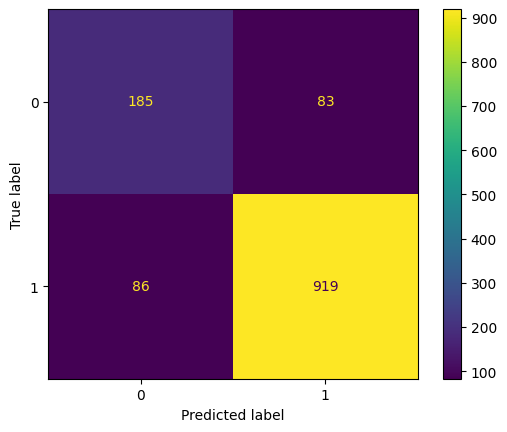

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = modelo3.predict(X_test)
cm = confusion_matrix(y_test, round(y_pred))

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
plt.show()


In [50]:
# Reporte de clasificación 
print(metrics.classification_report(y_test,round(y_pred)))


              precision    recall  f1-score   support

           0       0.68      0.69      0.69       268
           1       0.92      0.91      0.92      1005

    accuracy                           0.87      1273
   macro avg       0.80      0.80      0.80      1273
weighted avg       0.87      0.87      0.87      1273



El modelo reconoce a 927 de 1005 positivos (1) y a 180 de 268 negativos (0). 

**Matriz de confusión (punto de corte óptimo por Youden)**


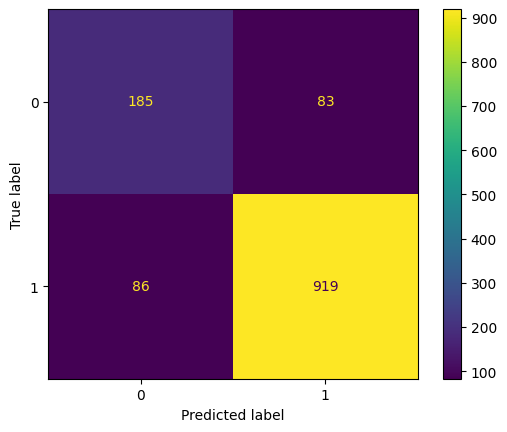

In [51]:
ConfusionMatrixDisplay(cm).plot()



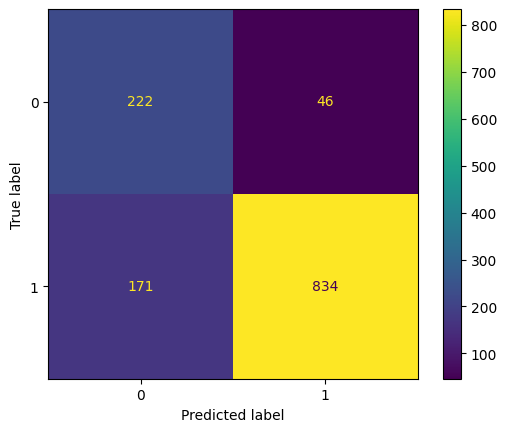

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = modelo3.predict(X_test)
y_clas =  y_pred.map(lambda x: 1 if x > 0.7 else 0)

cm = confusion_matrix(y_test, y_clas)

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display
plt.show(cm_display)


In [53]:
# Reporte de clasificación 
print(metrics.classification_report(y_test,y_clas))


              precision    recall  f1-score   support

           0       0.56      0.83      0.67       268
           1       0.95      0.83      0.88      1005

    accuracy                           0.83      1273
   macro avg       0.76      0.83      0.78      1273
weighted avg       0.87      0.83      0.84      1273



El modelo reconoce a 834 de 1005 positivos (1) y a 222 de 268 negativos (0). 



# Interpretación de parámetros del modelo logístico

Para interpretar el modelo es bueno hacer sobre los datos completos puesto que los estimadores resultarán más robustos al basarse en mayor cantidad de observaciones.


In [54]:
varObjBin

0       1
1       1
2       0
3       1
4       1
       ..
6360    0
6361    1
6362    1
6363    1
6364    1
Name: Compra, Length: 6365, dtype: category
Categories (2, int64): [0, 1]

In [55]:
# Ajustamos el modelo a datos completos para obtener estimadores más fiables
vinosDep = pd.concat([imputDep,varObjBin.astype('int64')], axis=1)

modeloF = logit(form3,data=vinosDep).fit()
modeloF.summary()


Optimization terminated successfully.
         Current function value: 0.306515
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Compra   No. Observations:                 6365
Model:                          Logit   Df Residuals:                     6356
Method:                           MLE   Df Model:                            8
Date:                Wed, 27 Nov 2024   Pseudo R-squ.:                  0.4108
Time:                        02:26:56   Log-Likelihood:                -1951.0
converged:                       True   LL-Null:                       -3311.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.3827      0.286      8.325      0.000       1.822       2.944
Clasificacion[T.*]       1.8162      0.086     21.016      0.000       1.647       1.986
Clasificacion[T.**+]     4.8510      0.163     29.753      0.000       4.531       5.171
Etiqueta[T.M]           -0.3719      0.194     -1.915      0.056      -0.753       0.009
Etiqueta[T.R]           -0.9724      0.189     -5.139      0.000      -1.343      -0.602
Etiqueta[T.B]           -1.3883      0.203     -6.843      0.000      -1.786      -0.991
Etiqueta[T.MB]          -1.6966      0.301     -5.628      0.000      -2.287      -1.106
CalifProductor          -0.4303      0.030    -14.170      0.000      -0.490      -0.371
pH                      -0.2202      0.061     -3.616      0.000      -0.340      -0.101
========================================================================================
"""

El summary del modelo nos da los betas, esto es la expresión lineal respecto al logit del modelo. Recordamos que el logit es el log(p(evento)/p(no evento)) = beta0 + beta1 x1 + ... betan xn

Entonces no se interpretan los betas como tal sino los Odds Ratio (OR) que son la exponencial de los parámetros beta. 

Para calcular los OR podríamos aplicar las exponenciales de forma manual.


In [56]:
np.exp(modeloF.params)



Intercept                10.833796
Clasificacion[T.*]        6.148224
Clasificacion[T.**+]    127.873457
Etiqueta[T.M]             0.689456
Etiqueta[T.R]             0.378178
Etiqueta[T.B]             0.249500
Etiqueta[T.MB]            0.183306
CalifProductor            0.650311
pH                        0.802340
dtype: float64

Conclusiones del modelo,

- La probabilidad de compra respecto a no compra de un vino con **Clasificación 2 o más estrellas** es 127 veces superior a aquellos vinos con clasificación desconocida.

- La probabilidad compra respecto a no compra de un vino con **Clasificación \* ** es 6,14 veces la correspondiente a aquellos vinos con clasificación desconocida. 

- Un aumento unitario en la **Calificación del productor** produce una disminución del ratio de probabilidades de compra/no compra del 35%.

- La probabilidad de compra de un vino con **Etiqueta MB** se reduce en un 82% con respecto a la de un vino con Etiqueta MM. 

- Cada aumento unitario del **pH** produce una reducción de la probabilidad de compra del 20%

Todos estos efectos se entiende en el contexto ceteris paribus, es decir, todo lo demás constante. Con lo cual, este aumento unitario del pH produce tal disminución en la probabilidad de compra para vinos con **misma** Etiqueta, Clasificación y Calificación del productor. 
